## CMA-ES vs Gradient methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import cma
import time

### 1. Introduction
This notebook aims to explore how the Covariance Matrix Adaptation Evolution Strategy (CMA-ES), a powerful gradient-free optimization algorithm, can be used to "train" the weights of a simple neural network. We will apply it to a binary classification problem.

The primary goal is not to showcase CMA-ES as the best method for standard neural network training. Instead, it's to:

- Demonstrate that it can optimize neural network weights by directly optimizing for a metric like accuracy (which can be seen as a non-differentiable objective from a certain perspective).
- Critically compare its performance (accuracy, computational effort) against a standard gradient-based training method (like Adam, as used in scikit-learn's MLPClassifier).
- Encourage you to be "suspicious" and ask critical questions when you encounter non-gradient methods being used for standard, differentiable neural network training tasks where gradient-based methods are well-established and highly efficient.

### 2. The Dataset: Two Moons
We'll use the "Two Moons" dataset, a classic non-linearly separable binary classification problem.

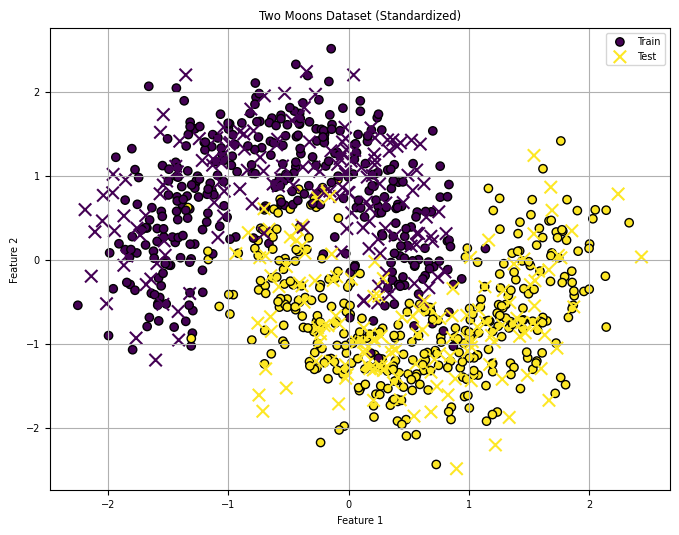

Training set shape: X=(700, 2), y=(700,)
Test set shape: X=(300, 2), y=(300,)


In [14]:
X, y = make_moons(n_samples=1000, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors="k", label="Train"
)
plt.scatter(
    X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker="x", s=80, label="Test"
)
plt.title("Two Moons Dataset (Standardized)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

print(f"Training set shape: X={X_train_scaled.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test_scaled.shape}, y={y_test.shape}")

### 3. Neural Network Definition
We will use a simple feedforward neural network with:

Input layer: 2 neurons (for our 2D data) <br>
Hidden layer: N_HIDDEN neurons with tanh activation. You can start with `N_HIDDEN=32` <br>
Output layer: 1 neuron with sigmoid activation (for binary classification probability) <br>
The parameters (weights and biases) of this network will be flattened into a single vector for CMA-ES to optimize.

In [38]:
N_INPUT_NODES = X_train_scaled.shape[1]
N_HIDDEN_NODES = 128
N_OUTPUT_NODES = 1

# Calculate the total number of parameters (D)
# Weights W1: N_INPUT x N_HIDDEN
# Biases b1: N_HIDDEN
# Weights W2: N_HIDDEN x N_OUTPUT
# Biases b2: N_OUTPUT
D = (N_INPUT_NODES * N_HIDDEN_NODES) + N_HIDDEN_NODES + \
    (N_HIDDEN_NODES * N_OUTPUT_NODES) + N_OUTPUT_NODES

print(f"Neural Network Architecture:")
print(f"Input Layer: {N_INPUT_NODES} neurons")
print(f"Hidden Layer: {N_HIDDEN_NODES} neurons (tanh activation)")
print(f"Output Layer: {N_OUTPUT_NODES} neuron (sigmoid activation)")
print(f"Total number of parameters (weights & biases) to optimize: D = {D}")

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nn_forward_pass(params_vector: np.ndarray, X_data: np.ndarray) -> np.ndarray:
    idx_end_W1 = N_INPUT_NODES * N_HIDDEN_NODES
    W1 = params_vector[0:idx_end_W1].reshape(N_INPUT_NODES, N_HIDDEN_NODES)

    idx_end_b1 = idx_end_W1 + N_HIDDEN_NODES
    b1 = params_vector[idx_end_W1:idx_end_b1]

    idx_end_W2 = idx_end_b1 + (N_HIDDEN_NODES * N_OUTPUT_NODES)
    W2 = params_vector[idx_end_b1:idx_end_W2].reshape(N_HIDDEN_NODES, N_OUTPUT_NODES)

    b2 = params_vector[idx_end_W2:]

    # Hidden layer
    hidden_layer_input = np.dot(X_data, W1) + b1
    hidden_layer_output = tanh(hidden_layer_input)

    # Output layer
    output_layer_input = np.dot(hidden_layer_output, W2) + b2
    output = sigmoid(output_layer_input)

    return output

Neural Network Architecture:
Input Layer: 2 neurons
Hidden Layer: 128 neurons (tanh activation)
Output Layer: 1 neuron (sigmoid activation)
Total number of parameters (weights & biases) to optimize: D = 513


### 4. Training with CMA-ES
We have to define a fitness function that CMA-ES will try to minimize. Since our goal is to maximize accuracy, our fitness will be 1.0 - accuracy.

The accuracy is calculated by:
- Performing a forward pass with the given parameters.
- Thresholding the sigmoid output (e.g., > 0.5 means class 1, else class 0).
- Comparing predicted classes to true labels.
- This direct use of accuracy (based on a hard threshold) makes the objective effectively non-differentiable with respect to the network parameters if one were to try to use calculus directly without a surrogate like cross-entropy.

### Visualizing the Decision Boundary (CMA-ES)
Let's see how the decision boundary learned by the CMA-ES-trained network looks.

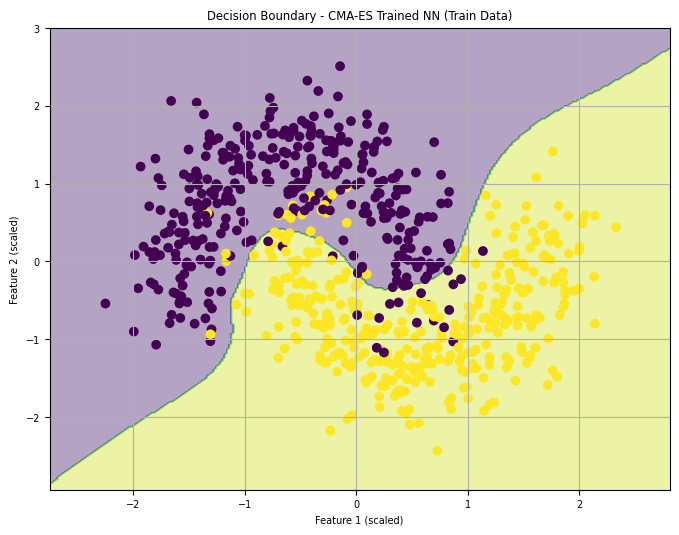

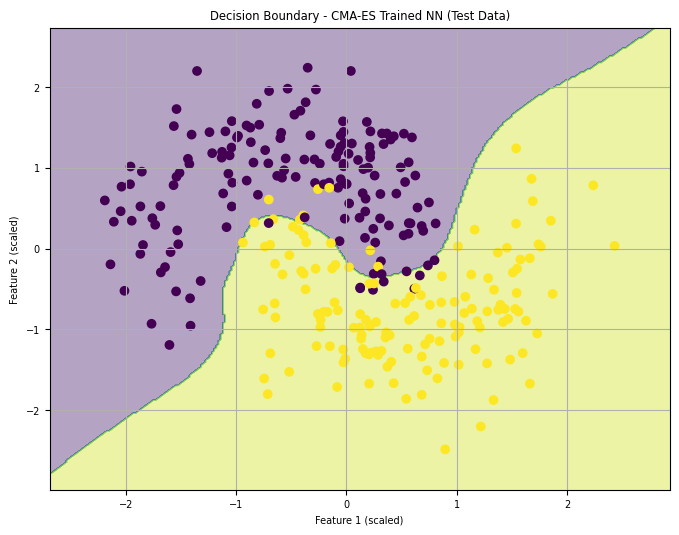

In [ ]:
def plot_decision_boundary(pred_func, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = .02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z_proba = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z_proba > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title(title)
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.grid(True)
    plt.show()

cma_pred_func = lambda x_data: nn_forward_pass(best_params_cma, x_data)

plot_decision_boundary(cma_pred_func, X_train_scaled, y_train, "Decision Boundary - CMA-ES Trained NN (Train Data)")
plot_decision_boundary(cma_pred_func, X_test_scaled, y_test, "Decision Boundary - CMA-ES Trained NN (Test Data)")

### 5. Training with a Standard Gradient-Based Method
Now, let's train a neural network with the same architecture using a standard gradient-based optimizer. You can use `scikit-learn`'s MLPClassifier, which employs optimizers like 'adam' or 'sgd' and uses a differentiable loss function (like cross-entropy) internally. Display decision boundary for a trained model.

### Exercise 1

Try to compare CMA-ES and MLPClassifier results for different sizes of a hidden layer. Try to compare both learning time and quality of results. 